In [ ]:
"""
https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition/notebook 참고
"""

In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler

In [3]:
# Figure settings
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

In [4]:
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

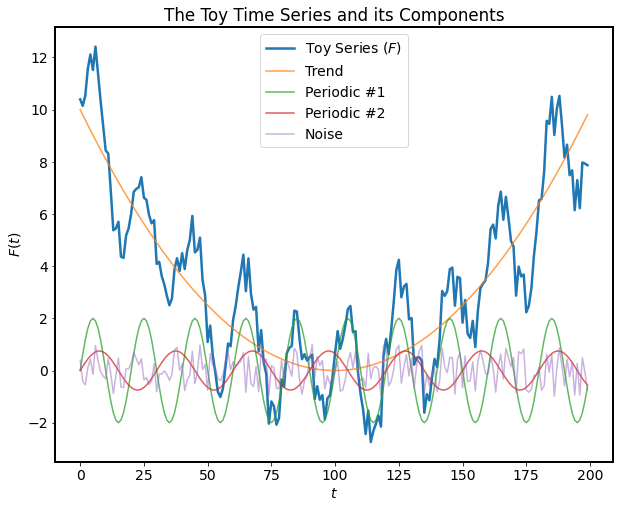

In [21]:
# Toy time series = f_t = 0.001 x (t - 100)^2 + 2sin(2pi*t/p1) + 0.75sin(2pi*t/p2) + Rand{-1, 1}
N = 200
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)
np.random.seed(123)
noise = 2 * (np.random.rand(N) - 0.5)

F = trend + periodic1 + periodic2 + noise  # f_t

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

In [22]:
L = 70
K = N - L + 1
X = np.column_stack([F[i:i+L] for i in range(0, K)])  # np.array 였으면 (K, L)인데 column_stack이라 (L, K)

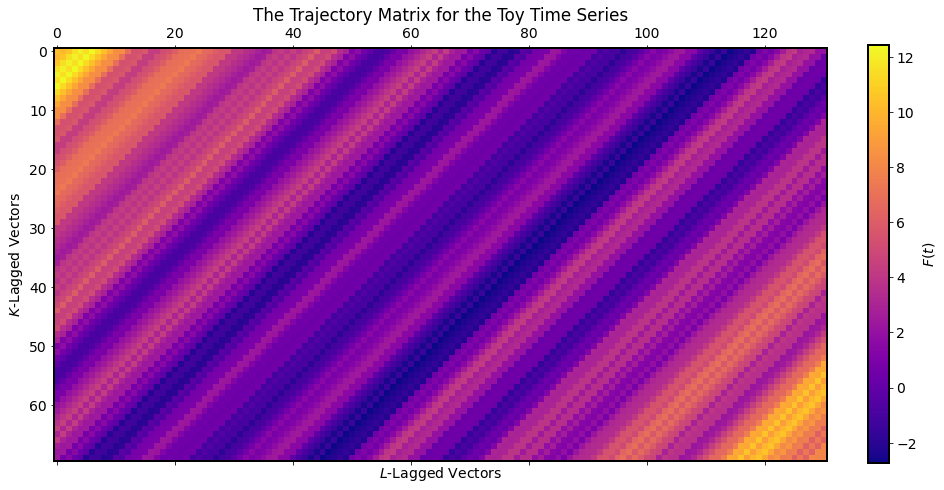

In [23]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

In [24]:
d = np.linalg.matrix_rank(X)

U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here.

# sigma_i * U_i * (V_i)^T for each i "or" sigma_i * outer_product(U_i, V_i).
# sigma 별 element 생성
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

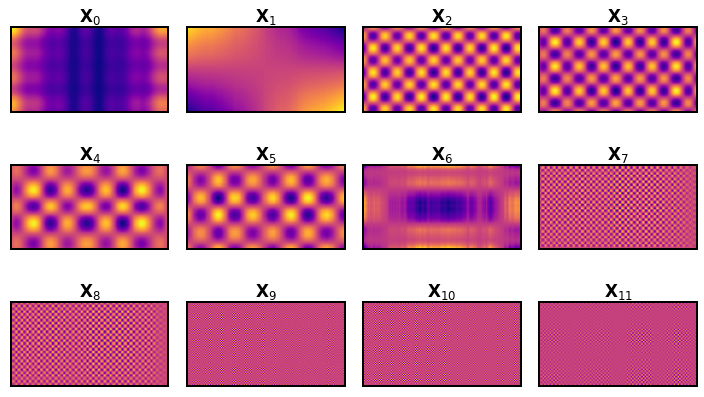

In [25]:
n = min(12, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    # fig 0, 2, 6 seem trend
    # fig 1, 3, 4, 5 seem periodicity
    # other figs seem noise (when noise removed, only x0~x6
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

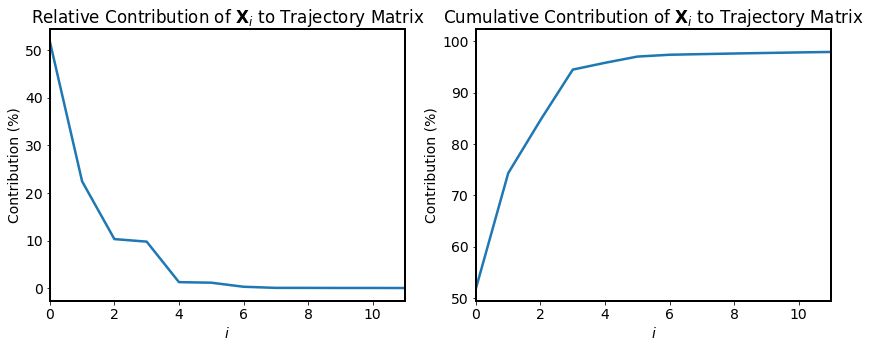

In [26]:
# eigen value 분포 확인
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)  # cumulative distribution
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

In [28]:
# 반대각 성분들은 사실상 하나의 time-series element를 나타내는데 계산 상 부정확함으로 모든 값이 같지 않다.
# 따라서 원래 element를 추정하기 위해 반대각 행렬들의 average를 낸다.

def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning.
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

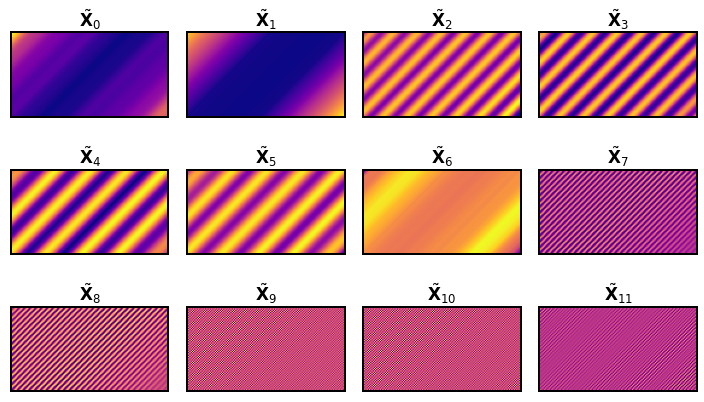

In [29]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

In [30]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    X_rev = X_i[::-1]  # diagonal 함수를 썼을 때 반대각 행렬이 나오도록 reverse 함.
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

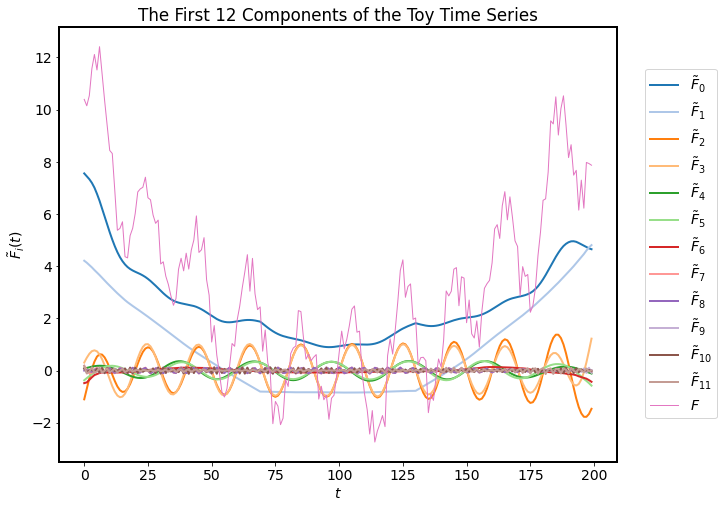

In [31]:
n = min(12,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

In [33]:
# 각 component들로부터 복원된 신호를 어떻게 결합해야 trend, periodic, noise로 grouping 할 것인가?
# correlation을 통해 비슷한 놈들은 grouping 하자
# weighted correlation를 구하는데 여기서 weight는 F_i 와 F_j 간 내적이며 orthogonal한 0부터 1까지다.

# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w),
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]


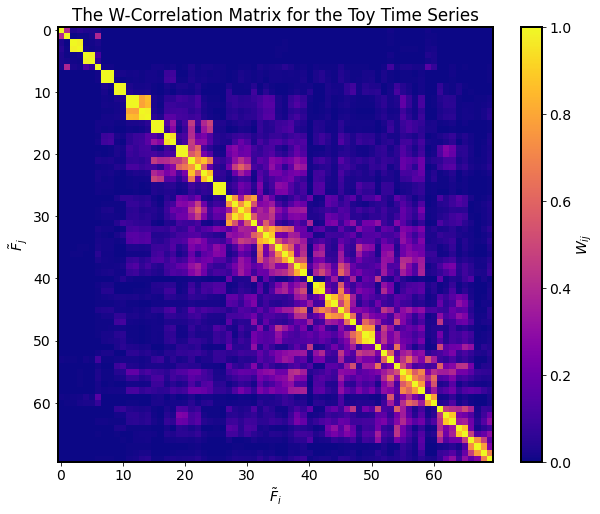

In [34]:
# 7 <= i, j <= 69 까지는 좀 서로 비슷한 정사각형이 보이는 듯 하다.
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Toy Time Series");

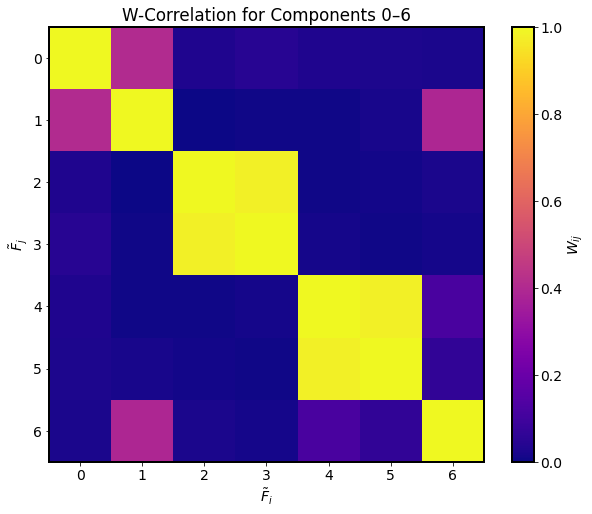

In [37]:
# F_2와 F_3 강한 관계성 (periodic)
# F_4와 F_5 강한 관계성 (periodic)
# F_0, F_1 => F_6 까지 미약하게 관계성 연계 (trend)

ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5, 6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–6");

In [39]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

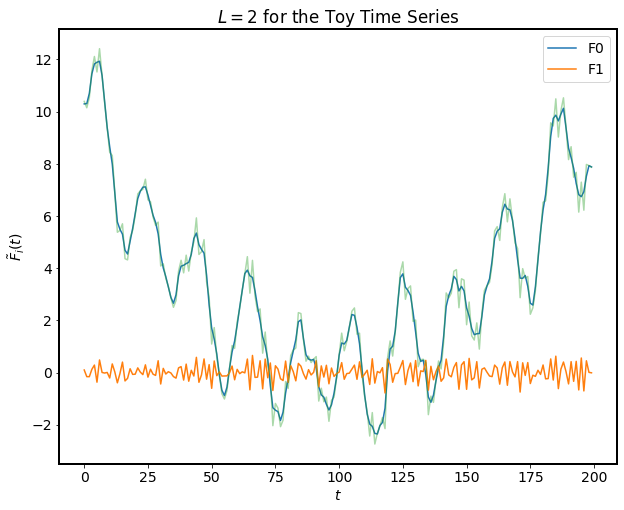

In [40]:
F_ssa_L2 = SSA(F, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series");

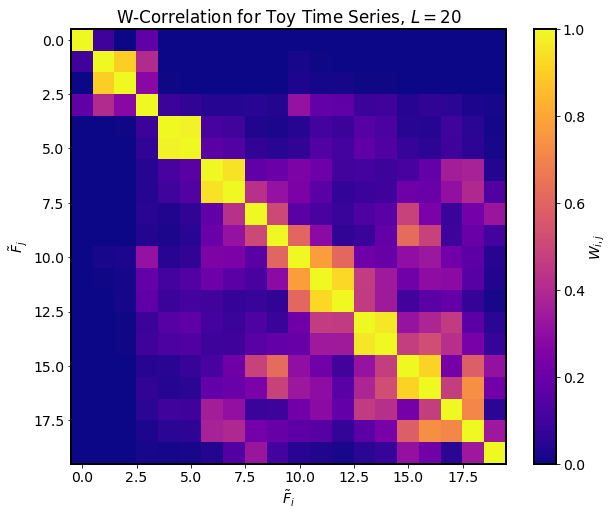

In [42]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=20$");

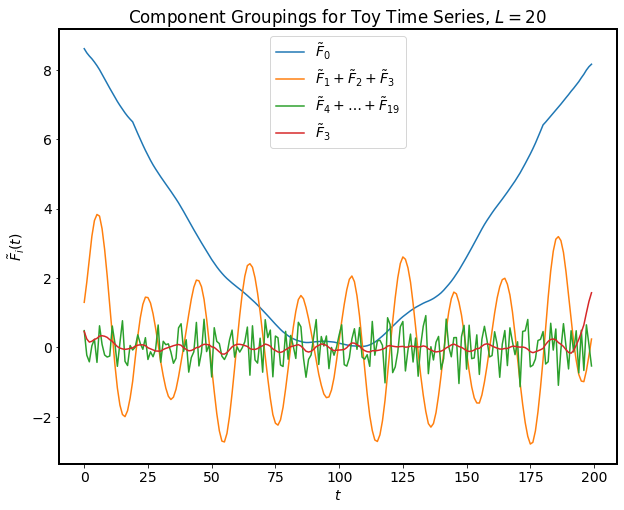

In [43]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct(slice(4,20)).plot()
F_ssa_L20.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$",
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);

# 실제 IMU SSA example

In [44]:
walk_1 = pd.read_csv("./data/MotionSense/A_DeviceMotion_data/wlk_15/sub_1.csv")

In [46]:
cols = ["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
accel_1 = (walk_1[cols]**2).sum(axis=1)**0.5  # magnitude of accel value
accel_1.index /= 50  # sampling rate = 50 Hz (time interval 0.02 s)

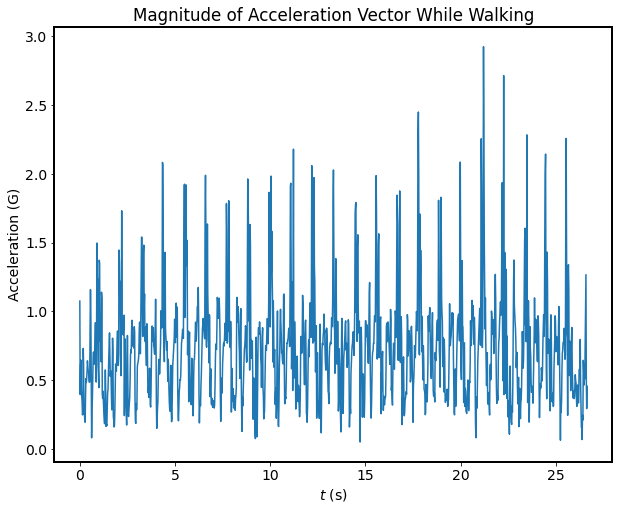

In [49]:
accel_1.plot()
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.title("Magnitude of Acceleration Vector While Walking");

In [51]:
def STFT(data, fft_size):
    overlap_fac = 0.5

    hop_size = np.int32(np.floor(fft_size * (1 - overlap_fac)))
    total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))

    window = np.hanning(fft_size)
    result = np.zeros((fft_size // 2, total_segments), dtype=np.float32)

    for i in range(total_segments):
        current_hop = hop_size * i
        segment = data[current_hop:current_hop + fft_size]

        if len(segment) < fft_size:
            segment = np.concatenate([segment, np.array([0] * (fft_size - len(segment)))])
        windowed = segment * window
        spectrum = np.fft.fft(windowed) / fft_size

        autopower = np.abs(spectrum * np.conj(spectrum))
        autopower = np.log10(autopower)

        result[:, i] = autopower[:fft_size // 2]
    return result

C:\Users\exosy\anaconda3\envs\jskim\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


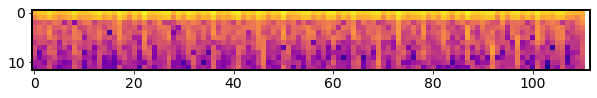

In [54]:
stft = STFT(accel_1.to_numpy(), 25)
plt.imshow(stft)

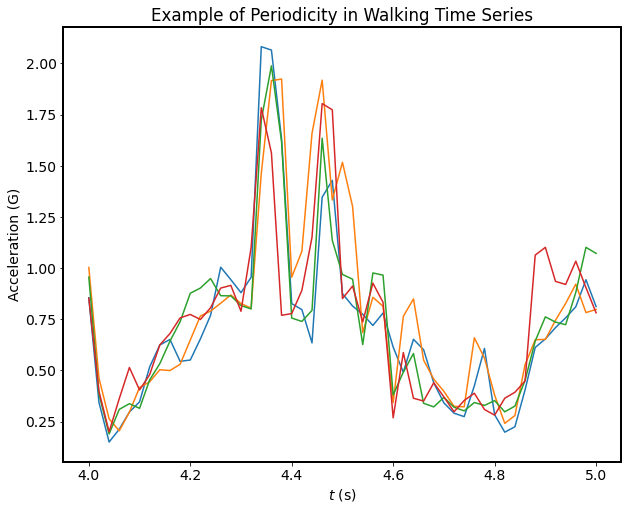

In [50]:
# 대충 56마다 periodic 하게 반복됨을 보여줌
# STFT로 해도 명확할거 같은데
accel_1.loc[4:5].plot()
accel_1.shift(-56).loc[4:5].plot()
accel_1.shift(-112).loc[4:5].plot()
accel_1.shift(-168).loc[4:5].plot()

plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.title("Example of Periodicity in Walking Time Series");

In [55]:
start = 10 # seconds, not samples
end = 25 # seconds
window = 350 # samples => window size가 period를 표현하기 충분하냐에 따라 다를 것 같음
accel_ssa = SSA(accel_1.loc[start:end], window)

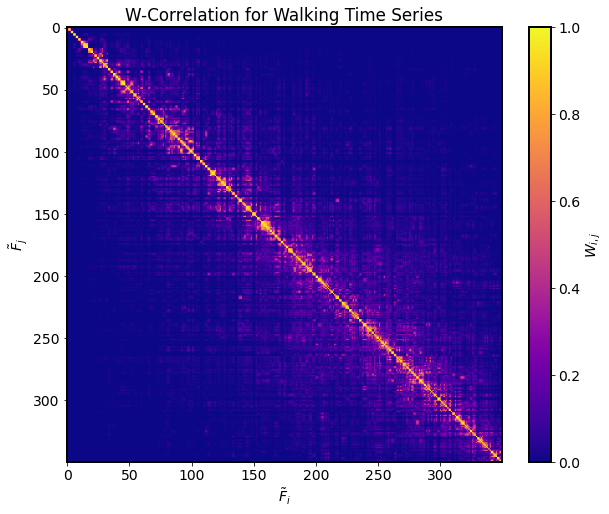

In [56]:
accel_ssa.plot_wcorr()
plt.title("W-Correlation for Walking Time Series");

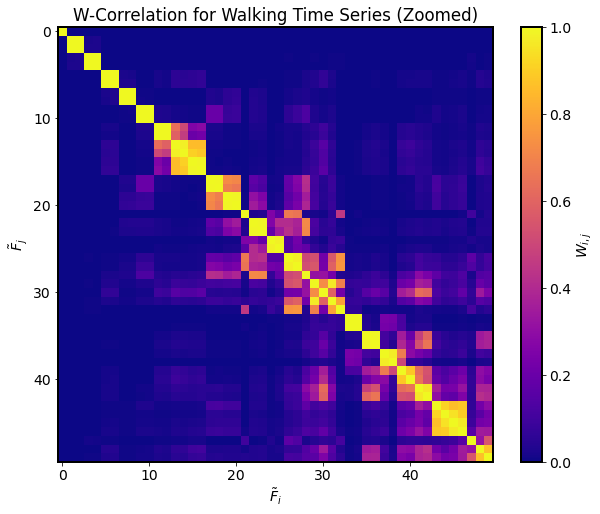

In [57]:
# 1, 2 / 3, 4/ 4, 5 등이 강한 관계성을 보임
accel_ssa.plot_wcorr(max=49)
plt.title("W-Correlation for Walking Time Series (Zoomed)");

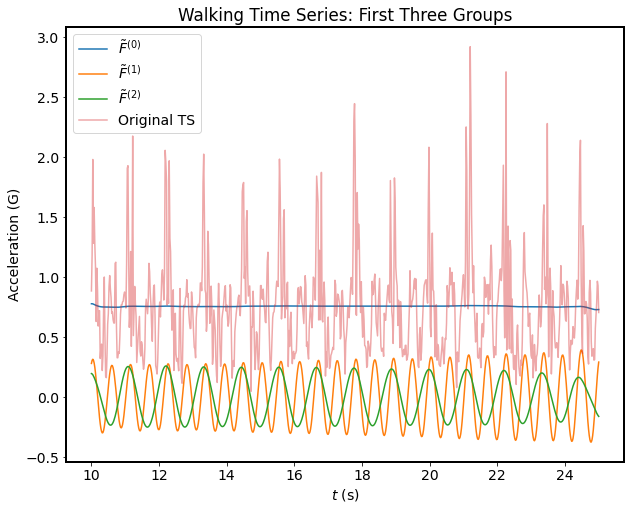

In [58]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: First Three Groups")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

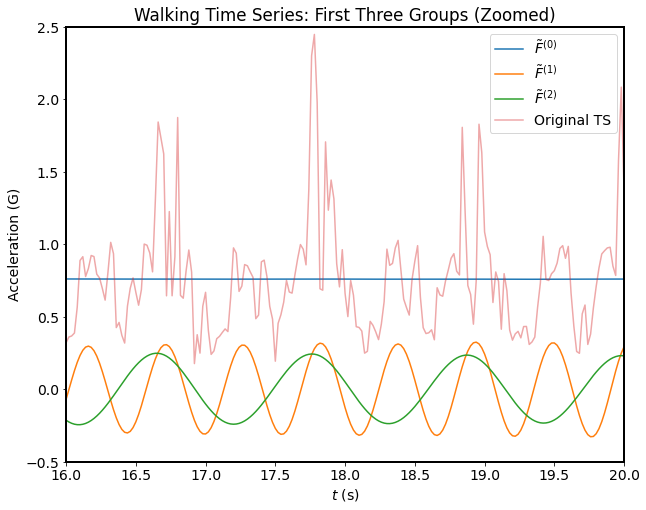

In [59]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: First Three Groups (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
# Zoom
plt.xlim(16,20)
plt.ylim(-0.5, 2.5)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

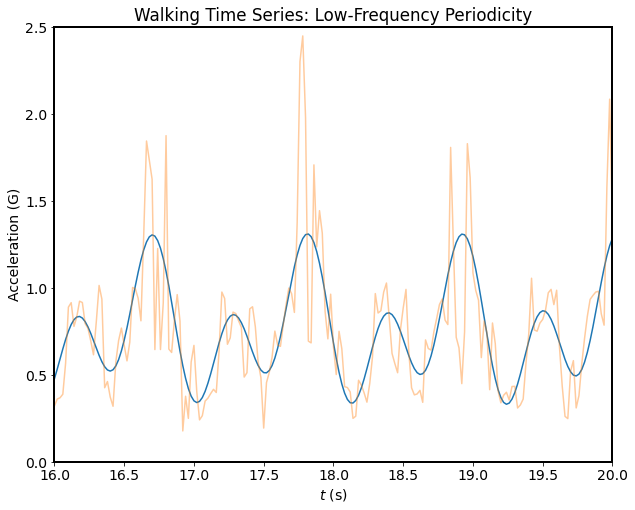

In [60]:
accel_ssa.reconstruct(slice(0,5)).plot()  # 앞의 것들이 대체로 주요한 패턴이니 데이터 특성을 잘 나타냄
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: Low-Frequency Periodicity")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(16,20)
plt.ylim(0, 2.5);

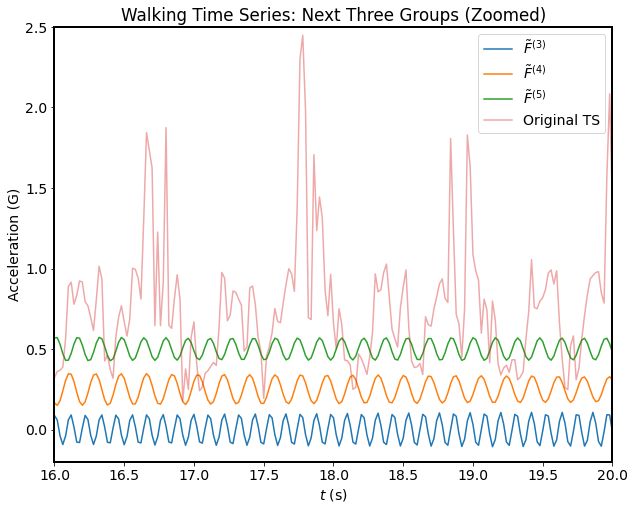

In [65]:
accel_ssa.reconstruct([5,6]).plot()
(accel_ssa.reconstruct([7,8]) + 0.25).plot() # Note: adding 0.25 to the series is for visualisation purposes only!
(accel_ssa.reconstruct([9,10]) + 0.5).plot() # Note: adding 0.5 to the series is for visualisation purposes only!
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: Next Three Groups (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(16,20)
plt.ylim(-0.2, 2.5)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3,6)] + ["Original TS"]
plt.legend(legend);

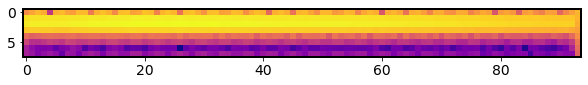

In [70]:
a = accel_ssa.reconstruct([7,8]).to_numpy()
stft = STFT(a, 16)  # f * 50/16
plt.imshow(stft)

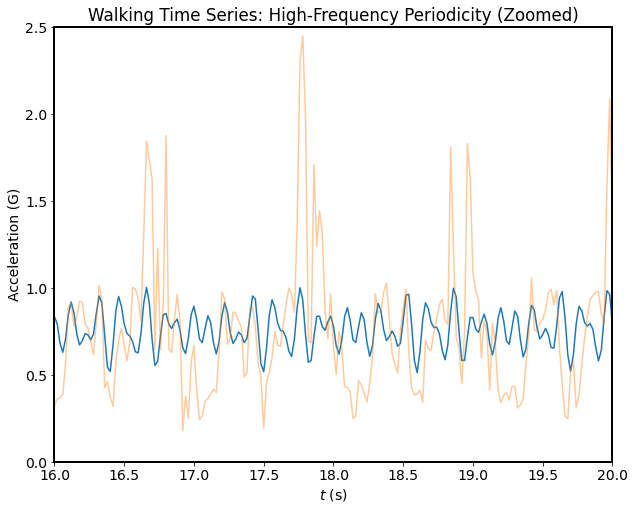

In [71]:
# 0 번째 component는 base이고 나머지는 별 의미없는 패턴
accel_ssa.reconstruct([0] + [i for i in range(5,11)]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: High-Frequency Periodicity (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.ylim(0, 2.5)
plt.xlim(16,20);

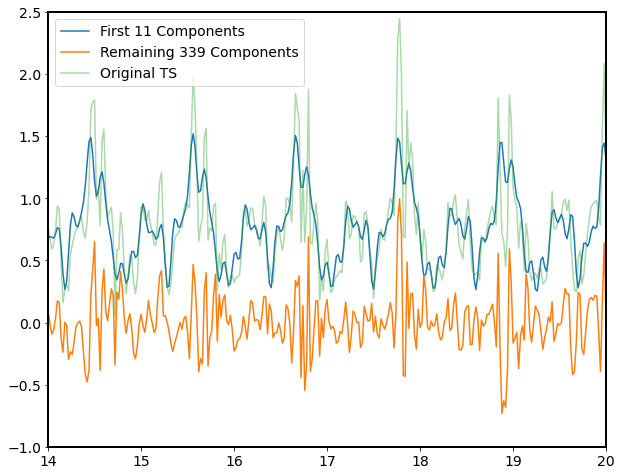

In [72]:
accel_ssa.reconstruct(slice(0,11)).plot()  # rather major
accel_ssa.reconstruct(slice(11,350)).plot()  # others
accel_ssa.orig_TS.plot(alpha=0.4)
plt.ylim(-1, 2.5)
plt.xlim(14,20)
plt.legend(["First 11 Components", "Remaining 339 Components", "Original TS"]);

# SSA로 Walking signature를 추출해보자

In [76]:
def extract_series(subject, walk):
    walk_dict = { 1 : "wlk_8", 2 : "wlk_15"}
    file_path = "./data/MotionSense/A_DeviceMotion_data/{}/".format(walk_dict[walk])
    file = "sub_{}.csv".format(subject)
    file_path += file
    walk = pd.read_csv(file_path)
    cols = ["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
    accel = (walk[cols]**2).sum(axis=1)**0.5

    # Convert acceleration values to z-scores.
    accel = (accel - accel.mean())/accel.std()

    # Convert index to units of seconds
    accel.index /= 50

    # Perform the SSA
    start = 10 # seconds, not samples
    end = 25 # seconds
    window = 350 # samples
    return SSA(accel.loc[start:end], window)

In [77]:
subjects = [3,5,21,1,22]
subject_ssa = {}

# Load and process the time series for each participant, storing the SSA objects.
# This will take a minute or two.
for subject in subjects:
    print("Subject #{}".format(subject))
    subject_ssa[subject] = extract_series(subject, 1), extract_series(subject, 2)

Subject #3
Subject #5
Subject #21
Subject #1
Subject #22


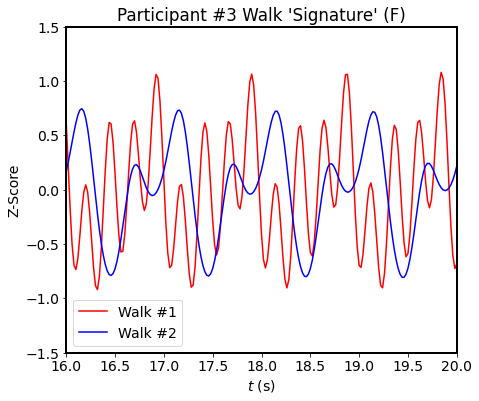

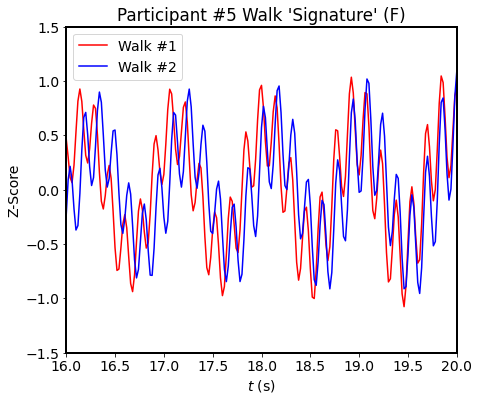

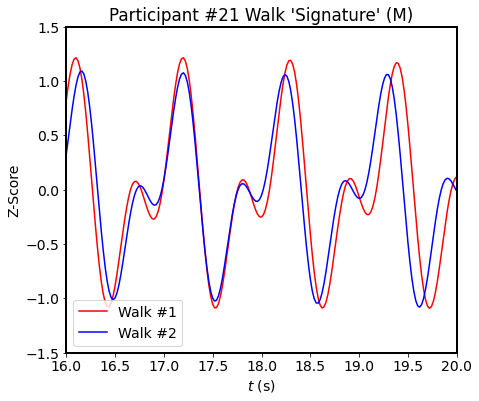

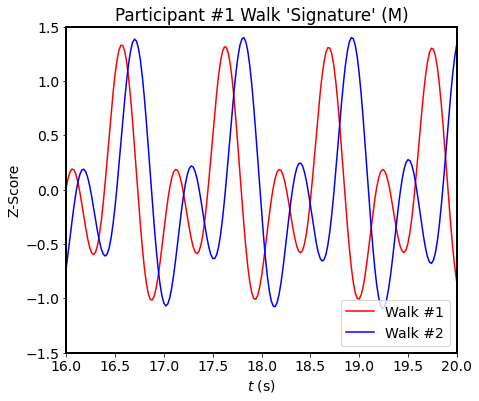

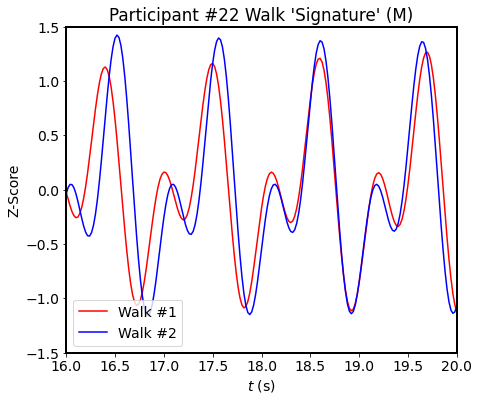

In [78]:
genders = ["F"]*2 + ["M"]*3
for subject, gender in zip(subjects, genders):
    ssa_1, ssa_2 = subject_ssa[subject]
    ssa_1.reconstruct(slice(0,4)).plot(color='red', figsize=(7,6))
    ssa_2.reconstruct(slice(0,4)).plot(color='blue')
    plt.xlim(16,20)
    plt.ylim(-1.5,1.5)
    plt.title("Participant #{} Walk 'Signature' ({})".format(subject, gender))
    plt.legend(["Walk #1", "Walk #2"])
    plt.xlabel(r"$t$ (s)")
    plt.ylabel("Z-Score")
    plt.show()

# Signature 비교안

reference: https://arxiv.org/pdf/1401.3973.pdf
=> time series similarity measures 정리됨